## Indicators assigned:


**Momentum Indicator:** Stochastic Oscillator\
**Volume Indicator:** Accumulation and Distribution Line Indicator\
**Volatility Indicator:** Implied Volatility

In [4]:
#dependencies: pandas, numpy, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Processing Data

In [5]:
df = pd.read_csv('datasets/btc_lim.csv', skiprows=range(1,15000), nrows=1000)
df.set_index('datetime', inplace=True)
df.drop(columns='Unnamed: 0',inplace=True)
df

,open,high,low,close,volume
datetime,,,,,
2021-05-25 16:00:00,38270.00,38295.78,37654.72,37796.55,21543.260
2021-05-25 17:00:00,37794.65,38057.94,37500.00,37948.67,15914.007
2021-05-25 18:00:00,37948.67,38303.86,37754.81,37880.83,13647.956
2021-05-25 19:00:00,37880.83,37978.20,37120.11,37293.26,18435.564
2021-05-25 20:00:00,37293.25,37805.27,37253.43,37600.68,13572.663
...,...,...,...,...,...
2021-07-06 03:00:00,33886.41,33943.52,33800.25,33896.83,10324.349
2021-07-06 04:00:00,33896.82,34760.55,33886.07,34623.48,54771.626
2021-07-06 05:00:00,34623.48,34853.06,34590.00,34769.69,22823.101


# Question 1



## Stochastic Oscillator:
The parameters I used in this were:\
**lookback period** = 11, since BTC is volatile and we are trading it on an hourly basis, used something slightly less than the default value of 14.\
**%K smoothing period** was chosen as 2 instead of the default 3, since the data given to backtest on was of bitcoin, which is volatile, and I wanted it to update frequently to make potential signals arent delayed.\
**%D smoothing period** was higher than the default, since it is a confirmation signal line and setting it equal to 4 will give a truer average of the %K line and will indicate potential reversals properly.\
**overbought/oversold levels** were chosen as 70/30 instead of the usual 80/20. again this was to look at the volatility of the bitcoin stock over a large amount of time.

**formula for calculating Stoch:**\
%K = ((current_close - lowest_low)/(highest_high - lowest_low))*100.     (in window_size = 11)\
smoothing line (slow %K) = EMA of %k over 2 periods\
signal line (%D) = EMA of %k over 5 periods



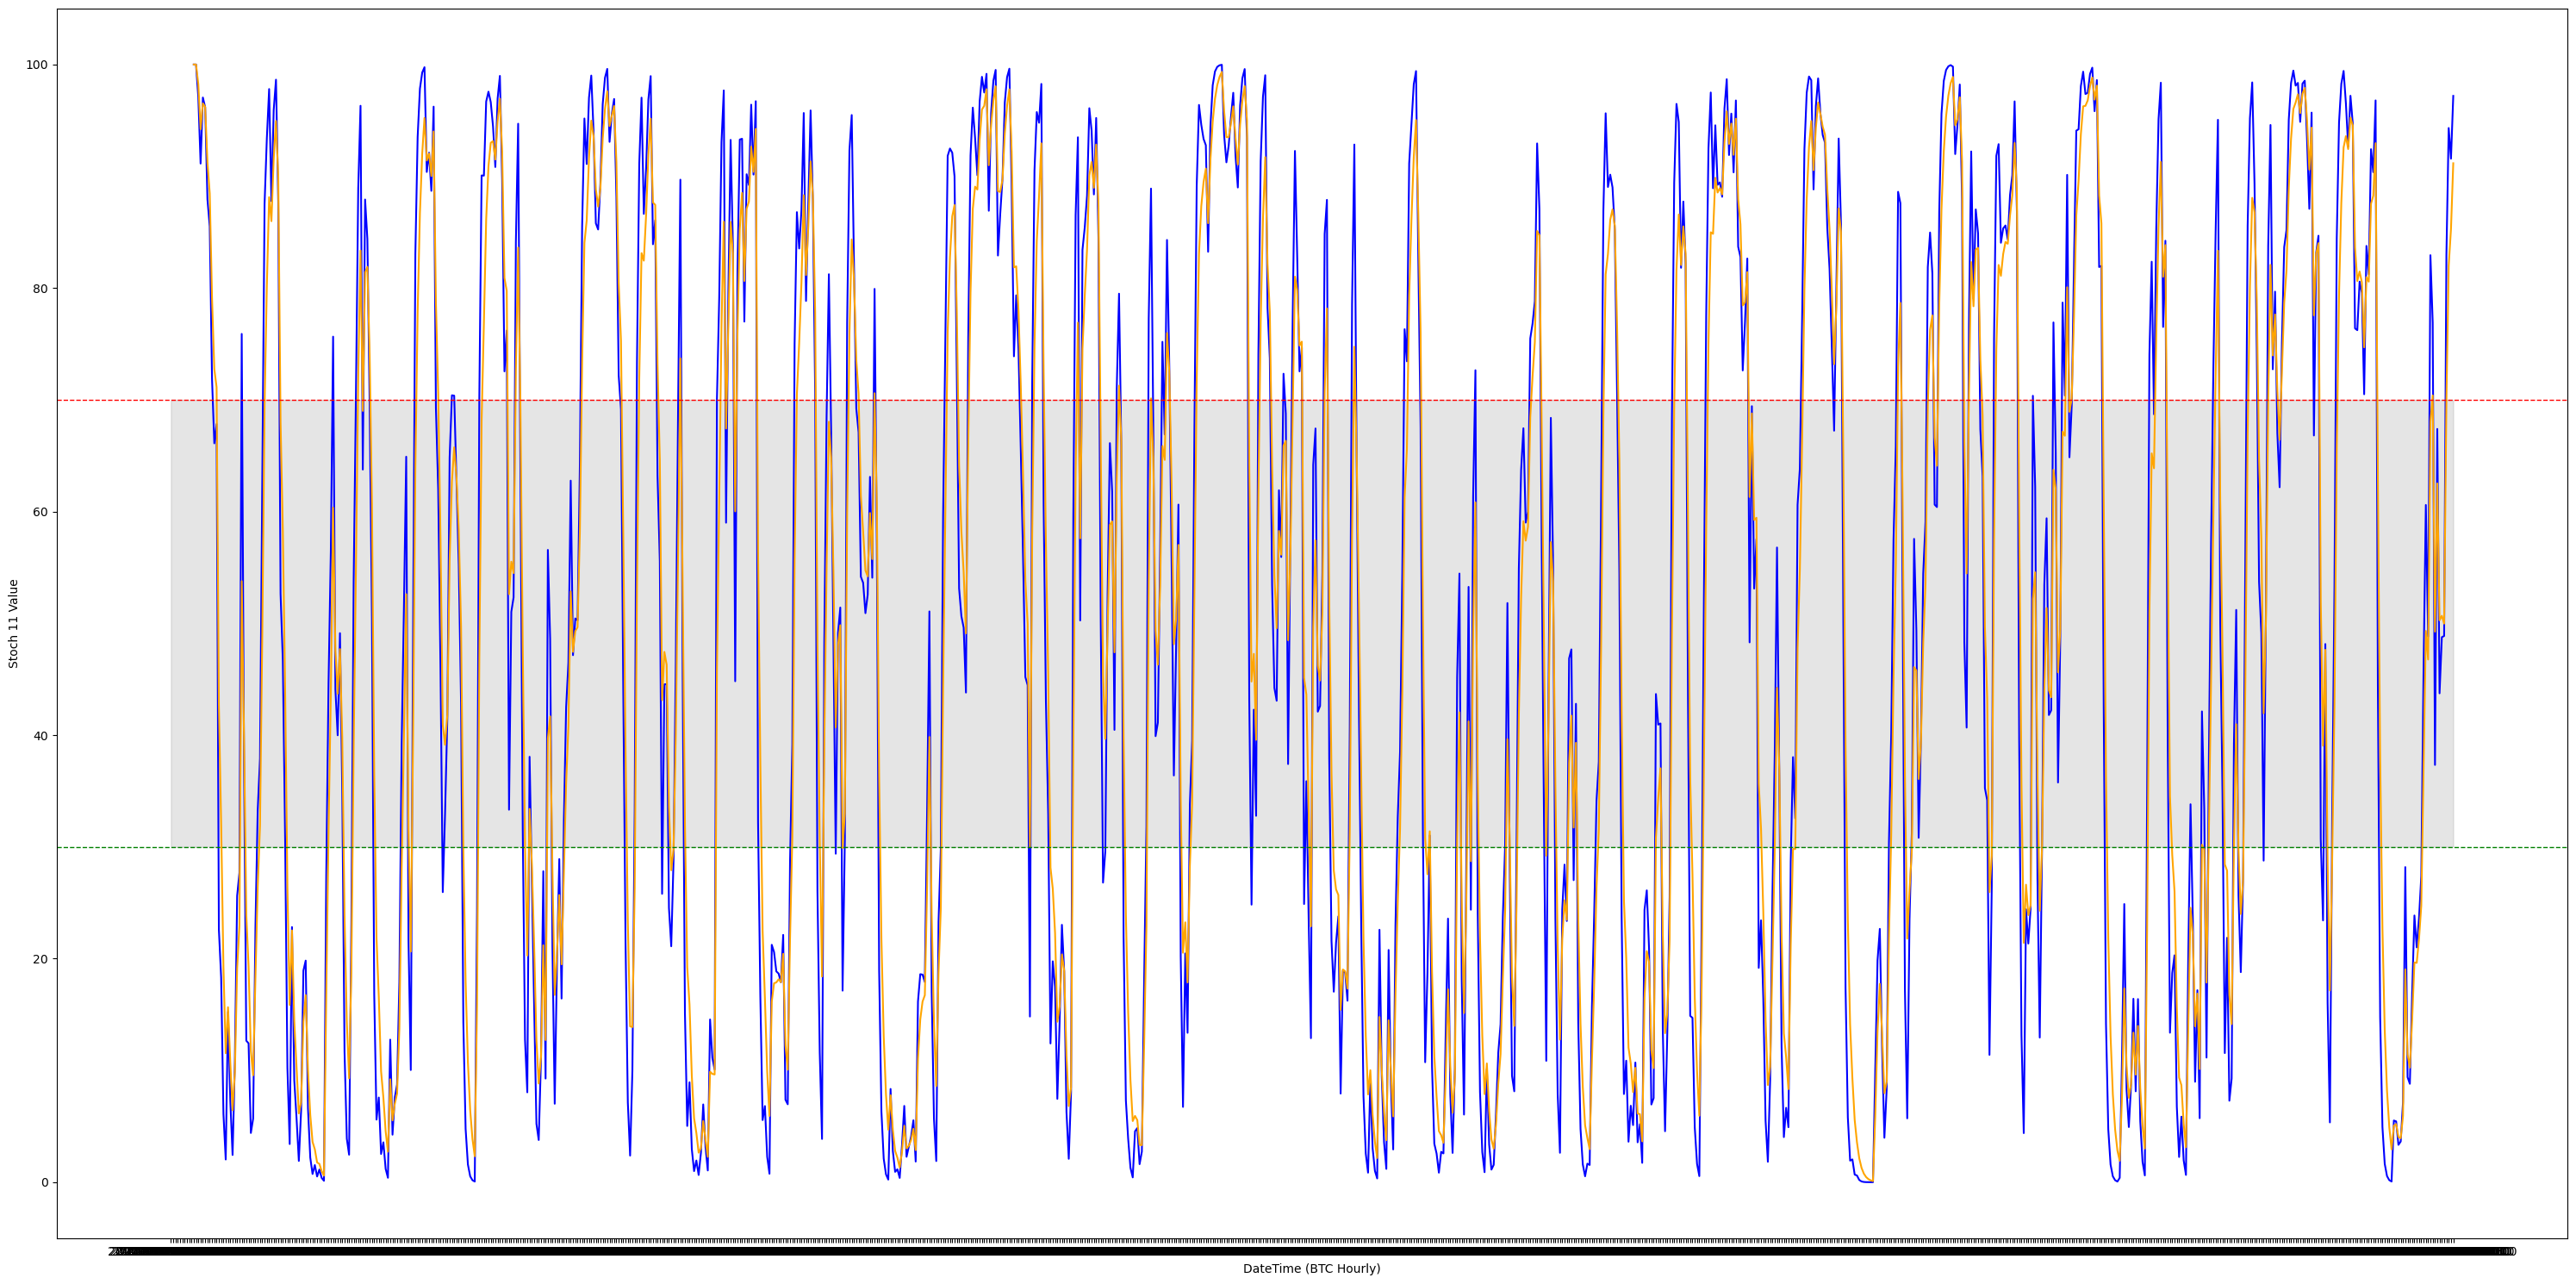

In [6]:
lookback_period = 11
k_smooth = 2
d_smooth = 4

df['lowest_low'] = df['close'].rolling(window=lookback_period).min()
df['highest_high'] = df['close'].rolling(window=lookback_period).max()

df['%K'] = ((df['close'] - df['lowest_low']) / (df['highest_high'] - df['lowest_low'])) * 100

df['%K_smoothed']  =df['%K'].ewm(span=k_smooth, adjust=False).mean() #this will be the fast moving line in blue
df['%D_signal'] = df['%K'].ewm(span=d_smooth, adjust=False).mean() #this will be the slow moving signal line in orange

plt.figure(figsize=(30, 15))
plt.plot(df['%K_smoothed'], label='%K line', color = 'blue')
plt.plot(df['%D_signal'], label='%D line', color = 'orange')
plt.fill_between(df.index, 30, 70, color='grey', alpha=0.2)  
plt.axhline(70, color='red', linestyle='--', linewidth=1) #overbought zone at 70
plt.axhline(30, color='green', linestyle='--', linewidth=1) #oversold zone at 30
plt.xlabel('DateTime (BTC Hourly)')
plt.ylabel('Stoch 11 Value')
plt.tight_layout()
plt.show()



this is a sample graph of how plotting this indicator looks like, over a period of around 1000 rows in the given dataset

## Accumulation and Distribution Line Indicator
cumulative volume indicator, theres no lookback period involved in this, changed nothing, just applied the formula and calculated it.

In [7]:
df['MFM'] = ((df['close'] - df['low']) - (df['high'] - df['close'])) / (df['high'] - df['low'])
df['MFV'] = df['MFM'].fillna(0) * df['volume']
df['A/D Line'] = df['MFV'].cumsum()


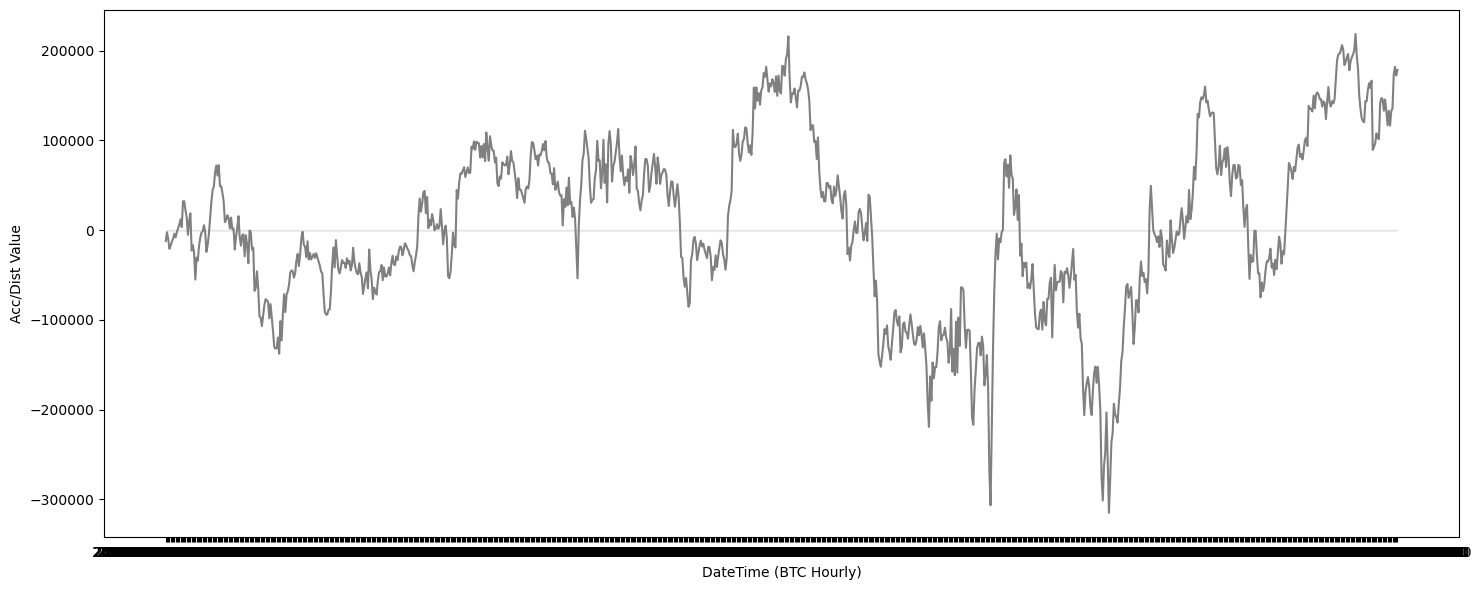

In [8]:
plt.figure(figsize=(15, 6))
plt.plot(df['A/D Line'], label='A/D Line', color = 'grey')
plt.fill_between(df.index, 30, 70, color='grey', alpha=0.2)  
plt.xlabel('DateTime (BTC Hourly)')
plt.ylabel('Acc/Dist Value')
plt.tight_layout()
plt.show()

this is a sample graph of how plotting the above indicator looks like; over a period of around 1000 rows in the given dataset.

## Implied Volatility
what i have: OHLCV hourly data of 3 year period.\
what i need to calculate IV: (data to plug into black-scholes eqn)\
options data: assuming european call option with a strike price of 5% above the current close price, expiring in a month from current date.\
risk free rate: assumed at 3%


**black-scholes formula:**\
underlying price = S = current close price.\
assuming price of call option at around 7% of the current closing price, ie C = 0.07 * current close.\
also assuming strike price to be at current close + 2%, ie strike price K = 1.02 * current close.\
assuming time period before expiry of call option, T = 30 days = 0.083 years.\
risk free rate, r = 3% = 0.03.\
we need to find sigma for which this happens (implied volatility).

used mibian library to do this, as i otherwise would have had to use numerical methods, which was very confusing.\
also this was hard to do over a large dataset, so i grouped by days instead of hours and calculated according to that (ie 24 lines ki ek IV value aayegi).


In [9]:
# import mibian as mb
# df.index = pd.to_datetime(df.index)
# dk = df.groupby(pd.Grouper(freq='D')).mean()
# dk['implied vol'] = 0
# for i in range(len(dk)):
#     #parameters to calculate IV
#     S = dk.iloc[i]['close']  #underlying
#     K = 1.02 * 10000 #strike price
#     T = 30 #days
#     r = 3 #risk free rate
#     market_price = 0.05 * 10000
#     option = mb.BS([S, K, r, T], callPrice=market_price)
#     dk.at[dk.index[i], 'implied vol'] = option.impliedVolatility

# plt.figure(figsize=(15, 6))
# plt.plot(dk['implied vol'], label='implied vol line', color = 'red')
# plt.xlabel('DateTime (BTC Hourly)')
# plt.ylabel('implied volatility value')
# plt.tight_layout()
# plt.show()



this is a sample graph of how plotting the above indicator looks like; over a period of around 1000 rows in the given dataset.

# Question 2:
## Stochastic Oscillator strategy + backtesting
So the rules for this strategy are: 

sell signal is given when both lines cross the overbought zone, and the %d line is above the %k line.\
buy signal is given when both lines are under the oversold line, and the %d line is below the %k line.\
when both or one of the lines are in the middle area, 0 signal is given, ie the position is held.

## Optimizations to the Stochastic Oscillator strategy: 
**Looking at the slope of the signal lines as well as their values**\
instead of just checking if the lines are over/under the overbought/oversold zones to generate sell/buy signals, we can also check if they are in the trend of exiting or entering the zones using either a pct_change or moving average.\
I will use the pct_change method for the slow moving line, if this returns a negative value, then the line is going down (which can generate a sell signal when slow line is just above overbought zone) and if it returns a positive value, then the line is going up (which can generate a buy signal when the slow line is just below the oversold zone).\
This is a measure to **confirm trend reversal** as it is possible for it to go into a sideways trend after entering into some zone.


**Take Profit and Stop Loss**  
I won't exactly be integrating a take profit part to it because I think it is best to just rely on the indicator.\
But I will sell immediately if the price goes below 0.8 times the entry price, so that gives a stop loss %age of 20%.
\
\
**Using these optimizations, I was able to increase profits by as much as 15-17%**

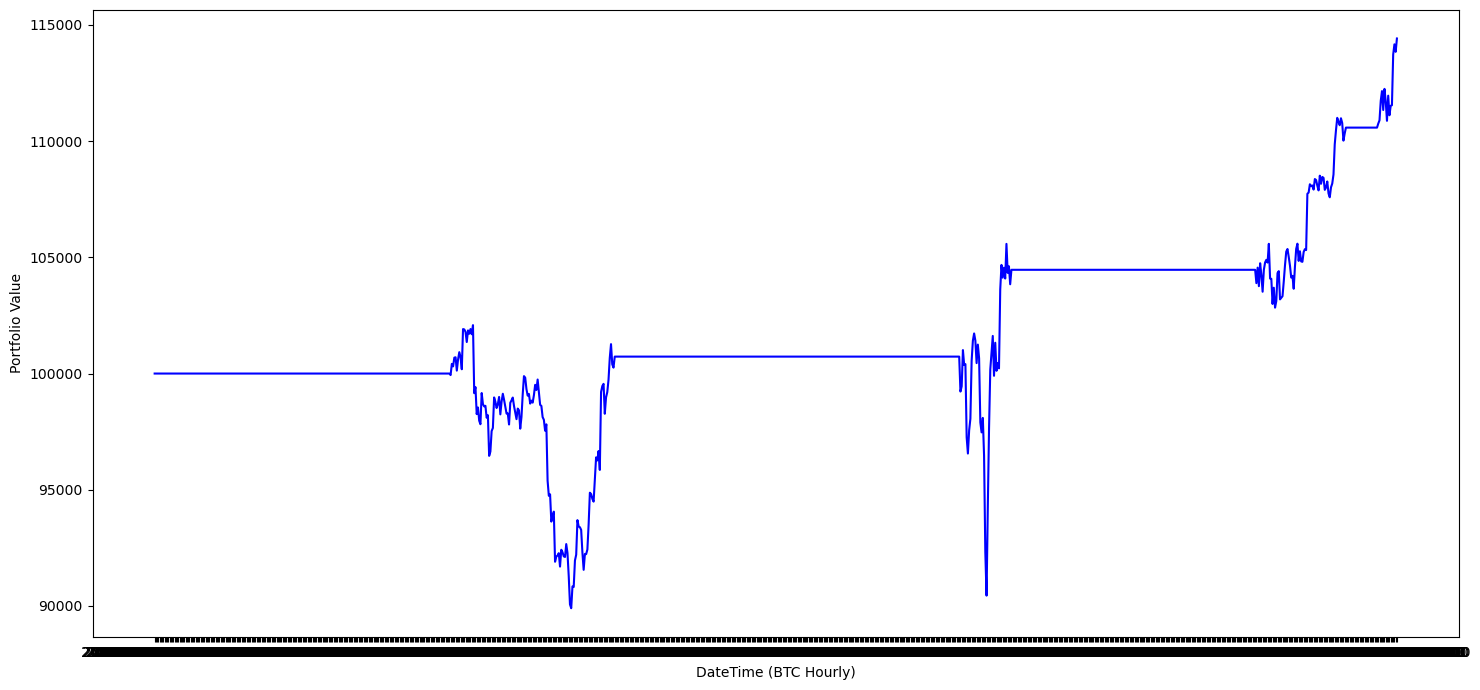

Total profit: 14415.969999999987

Overall Sharpe Ratio: -0.032984717002060196
Overall Sortino Ratio: -0.047169380200124345

Total number of trades: 3
-----> Number of losing trades: 0
-----> Number of winning trades: 3

Maximum drawdown percentage: -21.425%


In [10]:

class BacktestStoch:
    def __init__(self, df, initial_capital = 100000, lookback_period = 11,k_smooth = 2, d_smooth = 4, overbought=70, oversold=30, rfr = 0.03):
        self.df = df.copy()
        self.capital = initial_capital
        self.lookback_period = lookback_period
        self.k_smooth = k_smooth
        self.d_smooth = d_smooth
        self.position = False #boolean defined to check agar hold kar rhe ki nhi
        self.number = 0 #to track amount of stocks being held at a time
        self.overbought = overbought
        self.oversold = oversold
        self.order = []
        self.rfr = rfr
        
    
    def calc_stoch(self):
        self.df['lowest_low'] = self.df['close'].rolling(window=self.lookback_period).min()
        self.df['highest_high'] = self.df['close'].rolling(window=self.lookback_period).max()

        self.df['%K'] = ((self.df['close'] - self.df['lowest_low']) / (self.df['highest_high'] - self.df['lowest_low'])) * 100

        self.df['%K_smoothed']  = self.df['%K'].ewm(span=self.k_smooth, adjust=False).mean() #fast moving line 
        self.df['%D_signal'] = self.df['%K'].ewm(span=self.d_smooth, adjust=False).mean() #slow moving signal line 
    
        #signal generation part --> included optimization of checking for slope as well
        self.df['signal'] = 0
        self.df['slope'] = self.df['%D_signal'].pct_change()
        self.df.loc[(self.df['%K_smoothed'] <= self.oversold) & (self.df['%D_signal'] <= self.oversold) & (self.df['%D_signal'] <= self.df['%K_smoothed']) & (self.df['slope'] <= 0), 'signal'] = 1
        self.df.loc[(self.df['%K_smoothed'] >= self.overbought) & (self.df['%D_signal'] >= self.overbought) & (self.df['%D_signal'] >= self.df['%K_smoothed'])& (self.df['slope'] >= 0), 'signal'] = -1
        
        
    def trade(self, signal, price, time):
        if signal == 1 and self.position == False: #buy order
            self.entry = price
            if self.capital >= price:
                self.position = True
                self.number = self.capital // price
                self.order.append({'action': 'buy','number of shares': self.number, 'price of each': price, 'datetime': time})
                self.capital -= price*self.number #amount remaining after buying x number of shares
            elif self.capital < price:
                return
        elif signal == -1 and self.position == True: #sell order
            self.position = False
            exit = price*self.number
            self.order.append({'action':'sell','number of shares': self.number, 'price of each':price,'datetime':time})
            self.capital += (exit)
        
        #integrating stop loss optimization
        elif (signal == 0) and (self.position == True) and (price <= (0.8)*(self.entry)): #also a sell order immediately
            self.position = False
            exit = price*self.number
            self.order.append({'action':'sell','number of shares': self.number, 'price of each':price,'datetime':time})
            self.capital += (exit)
            
    def run_backtest(self):
        self.df['position'] = 0
        self.df['portfolio value'] = self.capital
        
        for i in range(len(self.df)):
            signal = self.df.iloc[i]['signal']
            price = self.df.iloc[i]['close']
            time = self.df.index[i]
            
            self.trade(signal, price, time)
            self.df.iloc[i, self.df.columns.get_loc('position')] = self.position
            self.df.iloc[i, self.df.columns.get_loc('portfolio value')] = self.capital + ((int(self.position)) * (price*self.number))
        
        self.orderbook = pd.DataFrame(self.order)    
        self.df.to_csv('main_1.csv')
        self.orderbook.to_csv('orderbook_1.csv')
        
        plt.figure(figsize=(15, 7))
        plt.plot(self.df['portfolio value'], label='portfolio value', color = 'blue')
        plt.xlabel('DateTime (BTC Hourly)')
        plt.ylabel('Portfolio Value')
        plt.tight_layout()
        plt.show() 
    
    def results(self):
        self.resdf = self.df[['portfolio value']].copy()
        
        #returns column
        self.resdf['Returns'] = (self.df['close'].pct_change())*100
        #risk adjusted returns column
        #assuming risk free rate of 3%, and hourly data with 252 trading days
        periods_per_year = 252*24
      
        self.resdf['Risk Adj Returns'] = self.resdf['Returns'] - (self.rfr/periods_per_year)
        
        #sharpe ratio calculation - assuming risk free rate of 3%
        volatility =  self.resdf['Returns'].std()
        self.resdf['Sharpe Ratio'] = (self.resdf['Returns'] - self.rfr) / volatility
        
        #sortino ratio calculation
        returns = self.resdf['Returns']
        downside_returns = returns[returns < 0]
        downside_volatility = downside_returns.std()
        self.resdf['Sortino Ratio'] = (self.resdf['Returns'] - self.rfr) / downside_volatility
        
        #winning and losing trades
        win = 0
        loss = 0
        for i in range(len(self.orderbook)-1):
            if self.orderbook.iloc[i]['action'] == 'buy':
                if self.orderbook.iloc[i]['price of each'] >= self.orderbook.iloc[i+1]['price of each']:
                    loss += 1
                else:
                    win += 1
                    
        #Maximum drawdown calculation
        maxval = self.resdf['portfolio value'].cummax()
        minval = self.resdf['portfolio value'].cummin()
        self.resdf['Drawdown %age'] = ((self.resdf['portfolio value'] - maxval) / maxval) * 100
        max_drawdown = round((((minval - maxval) / maxval) * 100).min(),3)
        
        
        #total profit calculation
        total_profit = self.resdf.iloc[-1]['portfolio value'] - self.resdf.iloc[1]['portfolio value']
        #net profit calculation is skipped because didnt include costs like trading fees etc in this backtest.
                 
        print(f"Total profit: {total_profit}") if total_profit > 0 else print(f"Strategy wasn't profitable. \n loss incurred: {total_profit}")
        print(f"\nOverall Sharpe Ratio: {self.resdf['Sharpe Ratio'].mean()}")   
        print(f"Overall Sortino Ratio: {self.resdf['Sortino Ratio'].mean()}")             
        print(f"\nTotal number of trades: {win+loss}")
        print(f"-----> Number of losing trades: {loss}")
        print(f"-----> Number of winning trades: {win}")
        print(f"\nMaximum drawdown percentage: {max_drawdown}%")
        self.resdf.to_csv('results_1.csv')
        
            
                            
engine = BacktestStoch(df)     
engine.calc_stoch()
engine.run_backtest()
engine.results()